### Edgar Moises Hernandez-Gonzalez
#### 05/03/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-3D, CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Escalogramas CWT (4D)
##### 5 ejecuciones independientes

#### CNN-3D
##### Sujeto 1
##### Accuracy = 54.86%
##### Kappa = 0.3981

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 47.92%
##### Kappa = 0.3056

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 40.62%
##### Kappa = 0.2083

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPool3D, Flatten, Dense, Dropout,
                                     TimeDistributed, Conv2D, MaxPool2D, LSTM,
                                     GRU, ConvLSTM2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#22 canales
def escalogramas(data):
  escalas = np.arange(1,129)
  dim = (112, 112) #ancho, alto
  datos = np.zeros((288,22,112,112))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      resized = cv2.resize(abs(coef), dim, interpolation=cv2.INTER_AREA)
      datos[i,j] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = escalogramas(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = escalogramas(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 22, 112, 112)
(288, 22, 112, 112)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

69.08683629763613
63.24737768255211
0.0001443754376485647
0.00014461887124935313


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.5397409
0.49412015
1.1279332e-06
1.1298349e-06


In [0]:
#convertir de 4D a 5D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))

print(x_train.shape)
print(x_test.shape)

(288, 22, 112, 112, 1)
(288, 22, 112, 112, 1)


In [0]:
'''def CNN_3D():
    model = Sequential()
    model.add(Conv3D(64, (1,3,3), activation='relu',
                     input_shape=x_train.shape[1:]))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(64, (1,3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

In [0]:
'''def CNN_3D_BN():
    model = Sequential()
    model.add(Conv3D(128, (1,3,3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    model.add(Conv3D(128, (1,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(16))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-6)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(8))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion va antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(16, (3,3), activation='relu',
                       input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [0]:
'''def Conv_LSTM_2D_BN():
    model = Sequential()
    model.add(ConvLSTM2D(64, (3,3), padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model'''

Iteration: 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 288 samples, validate on 288 samples
Epoch 1/100
288/288 - 14s - loss: 1.3868 - acc: 0.2465 - val_loss: 1.3858 - val_acc: 0.3125
Epoch 2/100
288/288 - 7s - loss: 1.3860 - acc: 0.2604 - val_loss: 1.3849 - val_acc: 0.2431
Epoch 3/100
288/288 - 7s - loss: 1.3844 - acc: 0.2847 - val_loss: 1.3844 - val_acc: 0.2569
Epoch 4/100
288/288 - 7s - loss: 1.3833 - acc: 0.3299 - val_loss: 1.3833 - val_acc: 0.2917
Epoch 5/100
288/288 - 7s - loss: 1.3822 - acc: 0.2986 - val_loss: 1.3824 - val_acc: 0.2535
Epoch 6/100
288/288 - 7s - loss: 1.3795 - acc: 0.2882 - val_loss: 1.3813 - val_acc: 0.2604
Epoch 7/100
288/288 - 7s - loss: 1.3781 - acc: 0.3750 - val_loss: 1.3803 - val_acc: 0.2778
Epoch 8/100
288/288 - 7s - loss: 1.3761 - acc: 0.3750 - val_loss: 1.3791 - val_acc: 0.2639
Epoch 9/100
288/288 - 7s - loss: 1.37

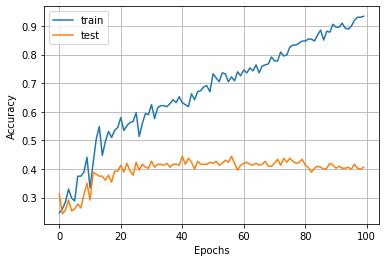

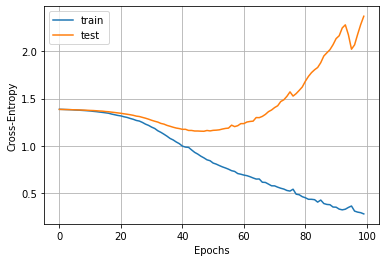


Resultados:
loss: [2.373101737764147]
accuracy: [0.40625]
kappa: [0.20833333333333337]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  #model = CNN_3D()
  #model = CNN_3D_BN()
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=100, batch_size=18,
                      validation_data=(x_test, y_test), verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 110, 110, 16)      9856      
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12390464  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 12,400,580
Trainable params: 12,400,580
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4062
std: (+/- 0.0000)
Mean Kappa: 0.2083
std: (+/- 0.0000)
Max Accuracy: 0.4062
Max Kappa: 0.2083
